# 1.3 LeNet Training for MNIST DIGITS

Syllabus:
1. Import Dependencies
2. Load Datasets
3. Create Model
4. Create Training Scheme Pytorch
5. Training Model

## 1. Import Dependencies

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

## 2. Load Datasets

In [3]:
# Download Training and Test data from PyTorch datasets
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

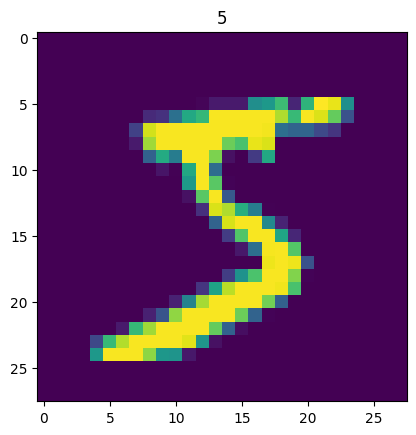

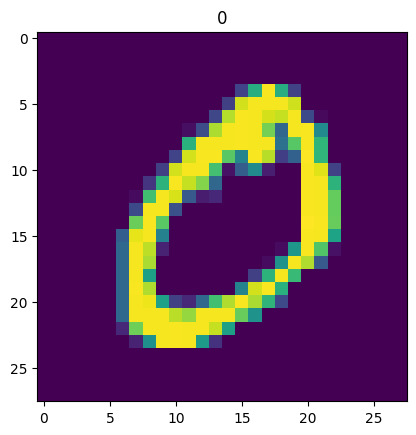

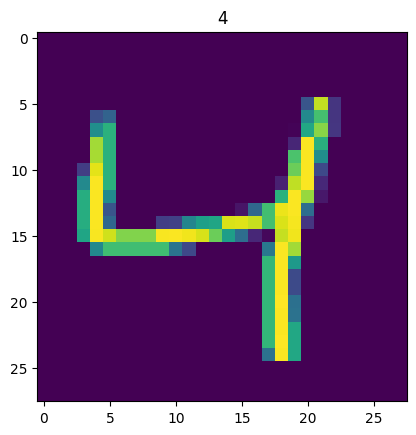

In [6]:
# Visualize the Data
import matplotlib.pyplot as plt

num_sample = 3

for i, data in enumerate(training_data):
    image, label = data
    plt.title(label)
    plt.imshow(image[0].numpy())
    plt.show()
    if i == num_sample-1:
        break

In [7]:
batch_size = 32

# Dataloader
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([32, 1, 28, 28])
Shape of y: torch.Size([32]) torch.int64


## 3. Create Model

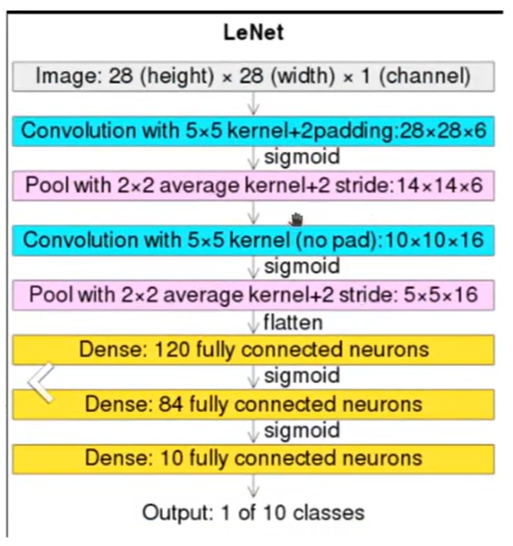

In [25]:
class LeNet(nn.Module):
    def __init__(self, input_channel=1, num_class=10):
        # input_chanel = 1 -> grayscale image
          # 3 (CIFAR-10, CIFAR-100) | 2,4,5 (Medical Scans: multi-slice, MRI, CT)
          # 2 (Optical Flow: video motion) | 4-12 (Satellite imagery: Multispectral (e.g RGB + IR + NDVI))
        # num_class = 10 -> number of digit classes (0-9)
          # 2 (Binary: Yes vs No) | 10 (Fashion-MNIST) | 100 (CIFAR-100)
          # 5 or else (Face recognition) | 50++ (Multilinugal OCR: A-Z + 0-9 + symbols)
        
        super().__init__()
        self.input_channel = input_channel
        self.num_class = num_class

        # Feature Extraction
        self.feature = nn.Sequential(
            # 32 filter channels -> fine-imaging
            nn.Conv2d(self.input_channel, 32, (5,5), padding=2),  # Convolution-1
            
            nn.MaxPool2d((2,2),2),                                # Pooling-1
            
            # Applies ReLU (Rectified Linear Unit) -> f(x) = max(0,x)
            # Replace negative values with 0
            # Adds non-linearity, speeds up training, avoids vanishing gradients.
            nn.ReLU(),                                            
            
            # 64 filter channels
            # No padding -> size shrinks
            nn.Conv2d(32, 64, (5,5)),                             # Convolution-2
            
            nn.MaxPool2d((2,2), 2),                               # Pooling-2
            
            nn.ReLU()
        )

        # Fully Connected (Dense)
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(5*5*64, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84,10),
        )
    
    def forward(self,x):
        return self.fc(self.feature(x))
    
        return x
    

In [19]:
model = LeNet()
print(model)

LeNet(
  (feature): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1600, out_features=120, bias=True)
    (2): ReLU()
    (3): Linear(in_features=120, out_features=84, bias=True)
    (4): ReLU()
    (5): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [ ]:
# Initialize Loss and Optimizer
loss_fn = nn.CrossEntropyLoss()     # Good for classification (10 classes)
optimizer = torch.optim.SGD(model.parameters(),lr=1e-3)

## 6. Create Training Scheme PyTorch

In [21]:
# Training in GPU
model.to('cuda')

LeNet(
  (feature): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1600, out_features=120, bias=True)
    (2): ReLU()
    (3): Linear(in_features=120, out_features=84, bias=True)
    (4): ReLU()
    (5): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    # Loops trough batches of data
    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to("cuda"), y.to("cuda")
        # Prediction
        pred = model(X)
        # Loss
        loss = loss_fn(pred, y)
        # Back Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()    
        # Print Loss every 100 batches
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

In [26]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()

    test_loss, correct = 0,0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to("cuda"), y.to("cuda")
            # Prediction
            pred = model(X)
            # Tracks Average Loss and Accuracy
            loss = loss_fn(pred, y)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1}%, Avg loss: {test_loss:>8f} \n")

In [24]:
# Training Loop
epochs = 100

for t in range(epochs):
    print(f"Epoch {t+1} \n ----------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1 
 ----------------------------
loss: 2.297165 [    0/60000]
loss: 2.317205 [ 3200/60000]
loss: 2.286702 [ 6400/60000]
loss: 2.280118 [ 9600/60000]
loss: 2.311318 [12800/60000]
loss: 2.300610 [16000/60000]
loss: 2.285344 [19200/60000]
loss: 2.297751 [22400/60000]
loss: 2.301781 [25600/60000]
loss: 2.279664 [28800/60000]
loss: 2.294480 [32000/60000]
loss: 2.301531 [35200/60000]
loss: 2.292951 [38400/60000]
loss: 2.286103 [41600/60000]
loss: 2.301887 [44800/60000]
loss: 2.292155 [48000/60000]
loss: 2.283433 [51200/60000]
loss: 2.291202 [54400/60000]
loss: 2.284952 [57600/60000]
Test Error: 
 Accuracy: 2e+01%, Avg loss: 2.283962 

Epoch 2 
 ----------------------------
loss: 2.279147 [    0/60000]
loss: 2.295277 [ 3200/60000]
loss: 2.272632 [ 6400/60000]
loss: 2.262625 [ 9600/60000]
loss: 2.292336 [12800/60000]
loss: 2.284378 [16000/60000]
loss: 2.261184 [19200/60000]
loss: 2.271649 [22400/60000]
loss: 2.273874 [25600/60000]
loss: 2.244340 [28800/60000]
loss: 2.267530 [32000/60000]